In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from datetime import timedelta, datetime
import matplotlib
import matplotlib.pyplot as plt

In [2]:
DIR = 'data/'

# 1. Metadata

In [3]:
meta = pd.read_json(DIR + 'metadata.json', lines=True)
meta.shape

(643104, 9)

In [4]:
meta.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [5]:
meta.columns

Index(['magazine_id', 'user_id', 'title', 'keyword_list', 'display_url',
       'sub_title', 'reg_ts', 'article_id', 'id'],
      dtype='object')

## Add 'reg_datetime', 'reg_dt' column

In [6]:
# POSIX timestamp 변환
atc = meta.copy()
atc['reg_datetime'] = atc['reg_ts'].apply(lambda x : datetime.fromtimestamp(x/1000.0))
atc.loc[atc['reg_datetime'] == atc['reg_datetime'].min(), 'reg_datetime'] = datetime(2090, 12, 31)
atc['reg_dt'] = atc['reg_datetime'].dt.date
atc['type'] = atc['magazine_id'].apply(lambda x : '개인' if x == 0.0 else '매거진')

In [7]:
atc.columns

Index(['magazine_id', 'user_id', 'title', 'keyword_list', 'display_url',
       'sub_title', 'reg_ts', 'article_id', 'id', 'reg_datetime', 'reg_dt',
       'type'],
      dtype='object')

In [8]:
atc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643104 entries, 0 to 643103
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   magazine_id   643104 non-null  int64         
 1   user_id       643104 non-null  object        
 2   title         643104 non-null  object        
 3   keyword_list  643104 non-null  object        
 4   display_url   643104 non-null  object        
 5   sub_title     643104 non-null  object        
 6   reg_ts        643104 non-null  int64         
 7   article_id    643104 non-null  int64         
 8   id            643104 non-null  object        
 9   reg_datetime  643104 non-null  datetime64[ns]
 10  reg_dt        643104 non-null  object        
 11  type          643104 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 58.9+ MB


In [9]:
atc.reg_datetime[:5,]

0   2016-09-27 11:47:07
1   2016-05-13 07:39:09
2   2015-11-20 14:28:07
3   2017-04-01 22:59:21
4   2018-04-10 01:55:42
Name: reg_datetime, dtype: datetime64[ns]

## Article count time-series plot

Text(0, 0.5, 'count')

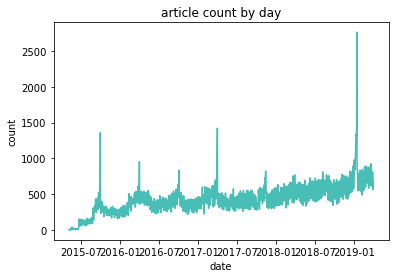

In [10]:
atc_cnt_by_reg_dt = atc.groupby('reg_dt', as_index=False)['article_id'].count()
sns.lineplot(data=atc_cnt_by_reg_dt[:-1], x='reg_dt', y='article_id', color='#49beb7')
plt.title('article count by day')
plt.xlabel('date')
plt.ylabel('count')

## Article count by weekday

In [11]:
atc_cnt_by_day = atc['article_id'].groupby(atc['reg_datetime'].dt.strftime('%A'))
atc_cnt_by_day_g = pd.DataFrame(atc_cnt_by_day.count())

<BarContainer object of 7 artists>

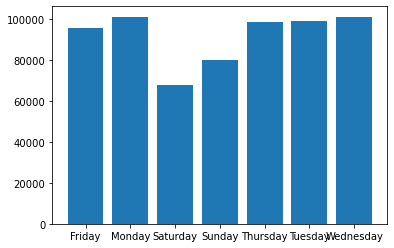

In [12]:
plt.bar(atc_cnt_by_day_g.index, atc_cnt_by_day_g.article_id)

## Article count by 24 hour

<BarContainer object of 24 artists>

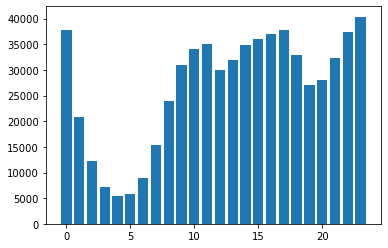

In [13]:
atc_cnt_by_hour = atc['article_id'].groupby(atc['reg_datetime'].dt.hour)
atc_cnt_by_hour_g = pd.DataFrame(atc_cnt_by_hour.count())
plt.bar(atc_cnt_by_hour_g.index, atc_cnt_by_hour_g.article_id)

# 2. User.json / Read.tar

In [14]:
import glob
import os
import re
from itertools import chain
import json

In [15]:
users = pd.read_json(DIR + '/users.json', lines = True)
users.shape

(310758, 3)

In [16]:
users.head()

,keyword_list,following_list,id
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62


In [17]:
def chainer(s):
    return list(chain.from_iterable(s))

users_follow = users['following_list'].map(len)
users_long = pd.DataFrame({'keyword_list': np.repeat(users['keyword_list'], users_follow),
                         'id': np.repeat(users['id'], users_follow),
                         'following_list': chainer(users['following_list'])})

In [18]:
users_long.head()

,keyword_list,id,following_list
0,[],#901985d8bc4c481805c4a4f911814c4a,@perytail
0,[],#901985d8bc4c481805c4a4f911814c4a,@brunch
1,[],#1fd89e9dcfa64b45020d9eaca54e0eed,@holidaymemories
1,[],#1fd89e9dcfa64b45020d9eaca54e0eed,@wadiz
1,[],#1fd89e9dcfa64b45020d9eaca54e0eed,@sciforus


### Read.tar 전처리

In [19]:
read_file_lst = glob.glob(DIR +'/read/*')
exclude_file_lst = ['read.tar']
read_df_lst = []
for f in read_file_lst:
    file_name = os.path.basename(f)
    if file_name in exclude_file_lst:
        print(file_name)
    else:
        df_temp = pd.read_csv(f, header=None, names=['raw'])
        df_temp['dt'] = file_name[:8]
        df_temp['hr'] = file_name[8:10]
        df_temp['user_id'] = df_temp['raw'].str.split(' ').str[0]
        df_temp['article_id'] = df_temp['raw'].str.split(' ').str[1:].str.join(' ').str.strip()
        read_df_lst.append(df_temp)

In [20]:
read = pd.concat(read_df_lst)

In [21]:
read.shape

(3507097, 5)

In [22]:
read.head()

,raw,dt,hr,user_id,article_id
0,#a055d0c3520e1c002531001928217887 @charlessay_...,20181121,14,#a055d0c3520e1c002531001928217887,@charlessay_30 @wal8am_27 @uglyduckmin_40 @ant...
1,#a9cba8bf098c149170315d4cd8d3082e @jinbread_88...,20181121,14,#a9cba8bf098c149170315d4cd8d3082e,@jinbread_88 @jinbread_87 @jinbread_89
2,#207c8cb590a843e247b9fe7fdd0e5281 @sangheeshyn...,20181121,14,#207c8cb590a843e247b9fe7fdd0e5281,@sangheeshyn_66
3,#d76887a5b30adbf793f742c6f67b57bd @tenbody_150...,20181121,14,#d76887a5b30adbf793f742c6f67b57bd,@tenbody_1506 @tenbody_1506
4,#b260d83247a4d9e3b22143c950f7f471 @maumdal_257...,20181121,14,#b260d83247a4d9e3b22143c950f7f471,@maumdal_257 @maumdal_257


In [23]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(' ')))

read_cnt_by_user = read['article_id'].str.split(' ').map(len)
read_raw = pd.DataFrame({'dt': np.repeat(read['dt'], read_cnt_by_user),
                         'hr': np.repeat(read['hr'], read_cnt_by_user),
                         'user_id': np.repeat(read['user_id'], read_cnt_by_user),
                         'article_id': chainer(read['article_id'])})

In [24]:
read_raw.head()

,dt,hr,user_id,article_id
0,20181121,14,#a055d0c3520e1c002531001928217887,@charlessay_30
0,20181121,14,#a055d0c3520e1c002531001928217887,@wal8am_27
0,20181121,14,#a055d0c3520e1c002531001928217887,@uglyduckmin_40
0,20181121,14,#a055d0c3520e1c002531001928217887,@anti-essay_133
0,20181121,14,#a055d0c3520e1c002531001928217887,@roysday_125


## Some summary scores

### Unique article id's

In [25]:
read_raw['article_id'].nunique()

505841

### Unique user id's

In [26]:
read_raw['user_id'].nunique()

306222

### Unique following author id's

In [27]:
users_long['following_list'].nunique()

16905

### Unique author id's

In [28]:
meta['user_id'].nunique()

19065

# 3. User-Item Interactions

### Following per User

In [29]:
follow_cnt = users_long['following_list'].value_counts(ascending=False)

In [30]:
# plt.bar(range(len(follow_cnt)), follow_cnt.values)

In [31]:
follow_cnt.describe()

count     16905.000000
mean        154.799113
std        2284.287830
min           1.000000
25%           5.000000
50%          17.000000
75%          80.000000
max      292413.000000
Name: following_list, dtype: float64

In [32]:
users_foll = users.copy()
users_foll['foll_cnt'] = users_foll.apply(lambda x: len(x['following_list']), axis = 1)
users_foll['foll_cnt'].describe()

count    310758.000000
mean          8.420955
std          30.286427
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        3528.000000
Name: foll_cnt, dtype: float64

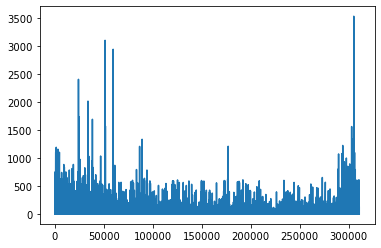

In [33]:
plt.plot(users_foll['foll_cnt'])

<AxesSubplot:xlabel='foll_cnt'>

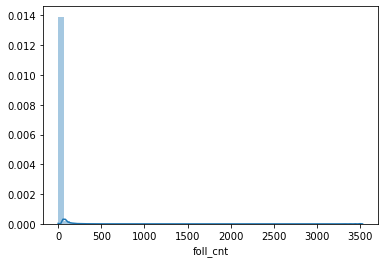

In [34]:
sns.distplot(users_foll['foll_cnt'])

In [43]:
users_foll[users_foll['foll_cnt']>=10].shape

(53106, 4)

following 여부를 user-item interaction으로 보면 matrix가 매우 sparse해짐

### View per User

In [37]:
read_view = read_raw.copy()
read_view.head()

,dt,hr,user_id,article_id
0,20181121,14,#a055d0c3520e1c002531001928217887,@charlessay_30
0,20181121,14,#a055d0c3520e1c002531001928217887,@wal8am_27
0,20181121,14,#a055d0c3520e1c002531001928217887,@uglyduckmin_40
0,20181121,14,#a055d0c3520e1c002531001928217887,@anti-essay_133
0,20181121,14,#a055d0c3520e1c002531001928217887,@roysday_125


In [38]:
read_cnt = pd.DataFrame(read_view['article_id'].groupby(read_view['user_id']).count())
read_cnt.describe()

,article_id
count,306222.000000
mean,72.204825
std,387.454923
min,1.000000
25%,3.000000
50%,11.000000
75%,39.000000
max,84840.000000


<AxesSubplot:>

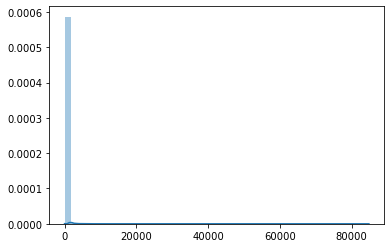

In [39]:
sns.distplot(read_cnt)

In [53]:
read_cnt.shape

(306222, 1)

In [59]:
read_cnt[read_cnt.values>=1000]

,article_id
user_id,
#003410c95e33d608695b3f68bffd09fe,1063
#004edd9f3d5d4fe9c0be82ff2e10f264,2503
#005751d603e3b2dbadd1bbd78daf7699,2606
#0058496055e45305828c00bd8cc488e9,1006
#0074f661772d7539392deb072c28c651,2191
...,...
#ff947fcc37a3804f53f3bd80a2b82282,1517
#ff9ae864fe221643723a2ad959444ebd,1338
#ffae495f7c65c0ab7cb4eac72e84bc20,1836


Training 기간 동안 1000개 이상 읽은 사람은 1% 정도...